In [793]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
# PyMC imports
import pymc as pm
import arviz as az
import seaborn as sb
# Scipy imports
from scipy.integrate import nquad
from scipy.optimize import fsolve
# other
#import harmonic as hm

# In the case that the covariance $\sigma$ is unknown

### **1. Model Setup**

Given the Bayesian Linear Regression model:

$$
y_i = x_i \theta_{1} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^{2})
$$

Our parameter space is:

$$
\Theta = \{ \theta_{1}, \theta_{2} \}, \quad \text{where} \quad \theta_{2} = \log(\sigma^{2})
$$

### **2. Likelihood Function**

The likelihood function is:

$$
P(\mathbf{y} | \Theta) = \frac{1}{(2\pi \sigma^{2})^{N/2}} \exp\left( -\frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{2\sigma^{2}} \right)
$$

Since $\sigma^{2} = e^{\theta_{2}}$, we can rewrite the likelihood as:

$$
P(\mathbf{y} | \Theta) = \frac{1}{(2\pi e^{\theta_{2}})^{N/2}} \exp\left( -\frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{2e^{\theta_{2}}} \right)
$$

### **3. Prior Distributions**

**For $\theta_{1}$:**

Assuming a Gaussian prior:

$$
P(\theta_{1}) = \frac{1}{(2\pi S_{1})^{p/2}} \exp\left( -\frac{\theta_{1}^{T} \theta_{1}}{2S_{1}} \right)
$$

**For $\theta_{2}$:**

Given the prior:

$$
P(\theta_{2}) = \frac{1}{\sqrt{2\pi \sigma_{2}^{2}}} \exp\left( -\frac{\theta_{2}^{2}}{2\sigma_{2}^{2}} \right)
$$

### **4. Hamiltonian Derivation**

The Hamiltonian is defined as:

$$
H(\Theta) = -\log P(\mathbf{y} | \Theta) - \log P(\theta_{1}) - \log P(\theta_{2})
$$

**Compute $-\log P(\mathbf{y} | \Theta)$:**

$$
\begin{align*}
-\log P(\mathbf{y} | \Theta) &= \frac{N}{2} \log(2\pi e^{\theta_{2}}) + \frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{2e^{\theta_{2}}} \\
&= \frac{N}{2} (\log 2\pi + \theta_{2}) + \frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{2e^{\theta_{2}}}
\end{align*}
$$

**Compute $-\log P(\theta_{1})$:**

$$
-\log P(\theta_{1}) = \frac{p}{2} \log(2\pi S_{1}) + \frac{\theta_{1}^{T} \theta_{1}}{2S_{1}}
$$

**Compute $-\log P(\theta_{2})$:**

$$
-\log P(\theta_{2}) = \frac{1}{2} \log(2\pi \sigma_{2}^{2}) + \frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}
$$

**Combine to get the Hamiltonian:**

$$
H(\Theta) = \frac{N}{2} (\log 2\pi + \theta_{2}) + \frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{2e^{\theta_{2}}} + \frac{p}{2} \log(2\pi S_{1}) + \frac{\theta_{1}^{T} \theta_{1}}{2S_{1}} + \frac{1}{2} \log(2\pi \sigma_{2}^{2}) + \frac{\theta_{2}^{2}}{2\sigma_{2}^{2}}
$$


In [794]:
def Hamiltonian(THETA: np.ndarray, MODEL: list) -> float:
    theta_1 = THETA[0]
    theta_2 = THETA[1]

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    prior_cov = MODEL[2]       # S1
    sigma_2 = MODEL[3]
    sigma_2_sq = sigma_2

    N = len(y_vec)

    y_hat = y_vec - (x_mat * theta_1)

    # Term: (N/2)(log(2π) + θ2)
    term1 = 0.5 * N * (np.log(2 * np.pi) + theta_2)
    
    # Terms: (1/2)log(2πS1) + (1/2)log(2πσ2^2)
    log_terms = term1 + 0.5 * np.log(2 * np.pi * prior_cov) + 0.5 * np.log(2 * np.pi * sigma_2_sq)
    
    # Term: ((y - Xθ1)^T (y - Xθ1)) / (2e^{θ2})
    exponential_term = 0.5 * np.exp(-theta_2) * np.dot(y_hat.T, y_hat) 
    
    # Term: θ1^2 / (2S1)
    prior_1_term = 0.5 * (theta_1 ** 2) / prior_cov
    
    # Term: θ2^2 / (2σ2^2)
    prior_2_term = 0.5 * (theta_2 ** 2) / sigma_2_sq

    # Sum all terms to get the Hamiltonian
    return log_terms + exponential_term + prior_1_term + prior_2_term


### **5. First Derivatives**

**Derivative with respect to $\theta_1$:**

$$
\frac{\partial H}{\partial \theta_1} = -\frac{\mathbf{X}^{T}(\mathbf{y} - \mathbf{X}\theta_1)}{e^{\theta_2}} + \frac{\theta_1}{S_1}
$$

**Derivative with respect to $\theta_2$:**

$$
\frac{\partial H}{\partial \theta_2} = \frac{N}{2} - \frac{1}{2e^{\theta_2}} (\mathbf{y} - \mathbf{X}\theta_1)^{T}(\mathbf{y} - \mathbf{X}\theta_1) + \frac{\theta_2}{\sigma_2^2} 
$$

In [795]:
def HamiltonianPrime(THETA: np.array, MODEL: list) -> np.array:
    theta_1 = THETA[0]
    theta_2 = THETA[1]

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    prior_cov = MODEL[2]
    sigma_2 = MODEL[3]
    sigma_2_sq = sigma_2

    N = len(y_vec)

    y_hat = y_vec - (x_mat * theta_1)

    h_prime_1 = -(np.dot(x_mat.T, y_hat) * np.exp(-theta_2)) + (theta_1 / prior_cov)
    h_prime_2 = 0.5 * N - (0.5 * np.exp(-theta_2) * np.dot(y_hat.T, y_hat)) + (theta_2 / sigma_2_sq)

    return np.array([h_prime_1, h_prime_2]).reshape(2, )

In [796]:

def HamiltonianPrime_2(THETA: np.ndarray, MODEL: list) -> np.ndarray:
    theta_2 = THETA[0]
    # theta_2 = THETA[1]

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    prior_cov = MODEL[2]
    sigma_2 = MODEL[3]
    sigma_2_sq = sigma_2
    N = len(y_vec)

    theta_10 = math.exp(-theta_2) * np.dot(x_mat.T, y_vec)
    numen = (1/prior_cov) + math.exp(-theta_2) * np.dot(x_mat.T, x_mat)
    theta_10 = theta_10 / numen

    y_hat = y_vec - (x_mat * theta_10)


    prime = 0.5 * N - (0.5 * np.exp(-theta_2) * np.dot(y_hat.T, y_hat)) + (theta_2 / sigma_2_sq)

    return np.array([prime])

### **6. Second Derivatives**

**Second derivative with respect to $\theta_{1}$:**

$$
\frac{\partial^2 H}{\partial \theta_{1} \partial \theta_{1}^{T}} = \frac{\mathbf{X}^{T} \mathbf{X}}{e^{\theta_{2}}} + \frac{1}{S_{1}}
$$

**Second derivative with respect to $\theta_{2}$:**

$$
\frac{\partial^2 H}{\partial \theta_{2}^2} = \frac{(\mathbf{y} - \mathbf{X}\theta_{1})^{T} (\mathbf{y} - \mathbf{X}\theta_{1}) }{2e^{\theta_{2}}} + \frac{1}{\sigma_{2}^2}
$$

**Mixed second derivative ($\theta_{1}$ and $\theta_{2}$):**

$$
\frac{\partial^2 H}{\partial \theta_{1} \partial \theta_{2}} = \frac{\mathbf{X}^{T} (\mathbf{y} - \mathbf{X}\theta_{1})}{e^{\theta_{2}}}
$$


In [797]:

def HamiltonianDoublePrime(THETA: np.array, MODEL: list) -> np.array:
    theta_1 = THETA[0]
    theta_2 = THETA[1]

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    prior_cov = MODEL[2]       # S1
    sigma_2 = MODEL[3]
    sigma_2_sq = sigma_2

    y_hat = y_vec - (x_mat * theta_1)

    Dinv = np.zeros((2, 2))
    Dinv[0, 0] = np.exp(-theta_2) * np.dot(x_mat.T, x_mat) + (1 / prior_cov)
    Dinv[1, 1] = 0.5 * np.exp(-theta_2) * np.dot(y_hat.T, y_hat) + (1 / sigma_2_sq)
    Dinv[0, 1] = Dinv[1, 0] = np.dot(x_mat.T, y_hat) * np.exp(-theta_2)

    return Dinv

In [798]:
def Hamiltonian_N_Prime(THETA: np.ndarray, MODEL: list) -> np.ndarray:
    theta_1 = THETA[0]
    theta_2 = THETA[1]

    x_mat = MODEL[0]
    y_vec = MODEL[1]

    y_hat = y_vec - (x_mat * theta_1)
    y_hat_sq = np.dot(y_hat.T, y_hat)
    x_mat_sq = np.dot(x_mat.T, x_mat)
    x_y_hat = np.dot(x_mat.T, y_hat)
    log_sigma2 = np.exp(-theta_2)

    Lmbd = []
    Lmbd.append([999])
    Lmbd.append([9999])
    Lmbd.append([99999])
    for i in range(3, 11):
        temp = np.zeros(tuple(2 for _ in range(i)))
        temp.flat[2**i - 1] = (-1)**i * 0.5 * log_sigma2 * y_hat_sq.item()

        poslist = set(itertools.permutations([0 if x < 1 else 1 for x in range(i)]))
        for k in poslist:
            temp[k] = (-1)**i * log_sigma2 * x_y_hat.item()

        poslist = set(itertools.permutations([0 if x < 2 else 1 for x in range(i)]))
        for k in poslist:
            temp[k] = (-1)**(i-2) * log_sigma2 * x_mat_sq.item()
        Lmbd.append(temp)

    return Lmbd

In [799]:
def MAP_SOLUTIONS(MODEL: np.ndarray) -> np.ndarray:
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    prior_cov = MODEL[2]

    theta_20 = fsolve(HamiltonianPrime_2, [0.1], args=(MODEL,))[0]

    theta_10 = math.exp(-theta_20) * np.dot(x_mat.T, y_vec)
    numen = (1/prior_cov) + math.exp(-theta_20) * np.dot(x_mat.T, x_mat)
    theta_10 = theta_10 / numen

    return theta_10, theta_20


In [818]:
# Your provided data
np.random.seed(42)
N = 200
p = 1
X_vec = np.random.uniform(-10, 10, N)
true_beta = 2
true_sigma = 5
epsilon = np.random.randn(N) * true_sigma
y_vec = (X_vec * true_beta) + epsilon
S_1 = 10  # Prior variance for theta_1

# Since sigma^2 is unknown in this case, we won't use true_sigma in the MODEL
# We need to set a prior variance for theta_2 (sigma_2^2)
prior_var_theta2 = 5.0  # You can adjust this as needed

# MODEL components: [Design matrix, Response vector, Prior variance for theta_1, Prior variance for theta_2]
MODEL = [X_vec, y_vec, S_1, prior_var_theta2]


In [819]:
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(S_1))
    log_sigma2 = pm.Normal('log_sigma2', mu=0, sigma=(np.sqrt(prior_var_theta2)))
    sigma2 = pm.Deterministic('sigma2', pm.math.exp(log_sigma2))
    sigma = pm.Deterministic('sigma', pm.math.sqrt(sigma2))

    # Likelihood
    likelihood = pm.Normal('y', mu=X_vec * beta, sigma=sigma, observed=y_vec)

    # Sampling
    trace = pm.sample(1000, chains=4, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, log_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [820]:
theta_10, theta_20 = MAP_SOLUTIONS(MODEL)
print(theta_10, theta_20)
map_solutions = np.array([theta_10, theta_20])
print(map_solutions)

j = -HamiltonianPrime(map_solutions, MODEL)
print(f'j: {j}')
Dinv = HamiltonianDoublePrime(map_solutions, MODEL)
print(f'Dinv: {Dinv}')
D = np.linalg.inv(Dinv)
print(f'D: {D}')
Lmbd = Hamiltonian_N_Prime(map_solutions, MODEL)

1.9767700258221328 3.1487971010029607
[1.9767700258 3.148797101 ]
j: [0. 0.]
Dinv: [[297.9613790018   0.1976770026]
 [  0.1976770026 100.8297594202]]
D: [[ 0.003356144  -0.0000065797]
 [-0.0000065797  0.0099177198]]


# Calculate the moments of the distrubution

In [821]:
mu0 = np.dot(D,j)
mu3 = (-0.5*np.einsum('ij,jkl,kl',D,Lmbd[3],D) -0.5*np.einsum('ij,jkl,km,m,ln,n',D,Lmbd[3],D,j,D,j))
mu4 = (-0.5*np.einsum('ij,jklm,kl,mn,n',D,Lmbd[4],D,D,j)
        -(1/6)*np.einsum('ij,jklm,kn,n,lo,o,mp,p',D,Lmbd[4],D,j,D,j,D,j))
mu5 = (-(1/8)*np.einsum('ij,jklmn,kl,mn',D,Lmbd[5],D,D)-
        (1/4)*np.einsum('ij,jklmn,ko,o,lp,p,mn',D,Lmbd[5],D,j,D,j,D)-
        (1/24)*np.einsum('ij,jklmn,ko,o,lp,p,mq,q,nr,r',D,Lmbd[5],D,j,D,j,D,j,D,j))
mu6 = (-(1/8)*np.einsum('ij,jklmno,kl,mn,op,p',D,Lmbd[6],D,D,D,j)-
        (1/12)*np.einsum('ij,jklmno,kl,mp,p,nq,q,or,r',D,Lmbd[6],D,D,j,D,j,D,j)-
        (1/120)*np.einsum('ij,jklmno,kp,p,lq,q,mr,r,ns,s,ot,t',D,Lmbd[6],D,j,D,j,D,j,D,j,D,j)+
        (1/2)*np.einsum('ij,jkl,km,ln,mno,op,p',D,Lmbd[3],D,D,Lmbd[3],D,j)+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nop,op',D,Lmbd[3],D,j,D,Lmbd[3],D)+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nop,oq,q,pr,r',D,Lmbd[3],D,j,D,Lmbd[3],D,j,D,j))
mu7 = (-(1/48)*np.einsum('ij,jklmnop,kl,mn,op',D,Lmbd[7],D,D,D)-
        (1/16)*np.einsum('ij,jklmnop,kl,mn,oq,q,pr,r',D,Lmbd[7],D,D,D,j,D,j)-
        (1/48)*np.einsum('ij,jklmnop,kl,mq,q,nr,r,os,s,pt,t',D,Lmbd[7],D,D,j,D,j,D,j,D,j)-
        (1/720)*np.einsum('ij,jklmnop,kq,q,lr,r,ms,s,nt,t,ou,u,pv,v',D,Lmbd[7],D,j,D,j,D,j,D,j,D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kl,mn,nop,op',D,Lmbd[4],D,D,Lmbd[3],D)+
        (1/4)*np.einsum('ij,jkl,km,ln,mnop,op',D,Lmbd[3],D,D,Lmbd[4],D)+
        (1/6)*np.einsum('ij,jklm,kn,lo,mp,nop',D,Lmbd[4],D,D,D,Lmbd[3])+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nopq,or,r,pq',D,Lmbd[3],D,j,D,Lmbd[4],D,j,D)+
        (1/4)*np.einsum('ij,jkl,km,ln,mnop,or,r,ps,s',D,Lmbd[3],D,D,Lmbd[4],D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kl,mn,nop,oq,q,pr,r',D,Lmbd[4],D,D,Lmbd[3],D,j,D,j)+
        (1/2)*np.einsum('ij,jklm,kn,n,lo,mp,opq,qr,r',D,Lmbd[4],D,j,D,D,Lmbd[3],D,j)+
        (1/4)*np.einsum('ij,jklm,kn,n,lo,o,mp,pqr,qr',D,Lmbd[4],D,j,D,j,D,Lmbd[3],D)+
        (1/6)*np.einsum('ij,jkl,km,m,ln,nopq,or,r,ps,s,qt,t',D,Lmbd[3],D,j,D,Lmbd[4],D,j,D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kn,n,lo,o,mp,pqr,qs,s,rt,t',D,Lmbd[4],D,j,D,j,D,Lmbd[3],D,j,D,j))
mu = mu0+mu3+mu4+mu5+mu6+mu7
print(mu)

[-0.0000095179  0.0097059499]


In [822]:
ip = map_solutions + mu
print(ip)
print(az.summary(trace))

[1.9767605079 3.1585030509]
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta         1.977  0.058   1.862    2.082      0.001    0.001    4575.0   
log_sigma2   3.160  0.103   2.958    3.342      0.002    0.001    4504.0   
sigma        4.862  0.251   4.384    5.312      0.004    0.003    4504.0   
sigma2      23.698  2.449  19.145   28.133      0.037    0.026    4504.0   

            ess_tail  r_hat  
beta          3300.0    1.0  
log_sigma2    3265.0    1.0  
sigma         3265.0    1.0  
sigma2        3265.0    1.0  


# Calculate pertubation of the higher order terms

In [823]:

# 4th order correction
d1 = -(1/8) * np.einsum('ijkl,ij,kl', Lmbd[4], D, D)

# 6th order correction
d2 = -(1/48) * np.einsum('ijklmn,ij,kl,mn', Lmbd[6], D, D, D) + \
     (1/8) * np.einsum('ijk,lmn,ij,kl,mn', Lmbd[3], Lmbd[3], D, D, D) + \
     (1/12) * np.einsum('ijk,lmn,il,jm,kn', Lmbd[3], Lmbd[3], D, D, D)

# 8th order correction
d3 = -(1/384) * np.einsum('ijklmnop,ij,kl,mn,op', Lmbd[8], D, D, D, D) + \
     (1/96) * np.einsum('ijkl,mnop,ij,km,ln,op', Lmbd[4], Lmbd[4], D, D, D, D) + \
     (1/48) * np.einsum('ijkl,mnop,im,jn,ko,lp', Lmbd[4], Lmbd[4], D, D, D, D) + \
     (1/32) * np.einsum('ijklm,nop,ij,kl,mn,op', Lmbd[5], Lmbd[3], D, D, D, D) + \
     (1/12) * np.einsum('ijk,lmnop,il,jm,kn,op', Lmbd[3], Lmbd[5], D, D, D, D)

# # 10th order correction
d4 = -(1/384) * np.einsum('ijklmnopuv,ij,kl,mn,op,uv', Lmbd[10], D, D, D, D, D) + \
     (1/240) * np.einsum('ijklm,nopuv,in,jo,kp,lu,mv', Lmbd[5], Lmbd[5], D, D, D, D, D) + \
     (1/4) * np.einsum('ijklm,nopuv,ij,kn,lo,mp,uv', Lmbd[5], Lmbd[5], D, D, D, D, D) + \
     (1/128) * np.einsum('ijklm,nopuv,ij,kl,mn,op,uv', Lmbd[5], Lmbd[5], D, D, D, D, D) + \
     (1/384) * np.einsum('ijklmn,opuv,ij,kl,mp,no,uv', Lmbd[6], Lmbd[4], D, D, D, D, D) + \
     (1/48) * np.einsum('ijklmno,puv,ij,kl,mn,op,uv', Lmbd[7], Lmbd[3], D, D, D, D, D) - \
     (1/72) * np.einsum('ijk,lmn,opuv,ij,ko,lm,np,uv', Lmbd[3], Lmbd[3], Lmbd[4], D, D, D, D, D) - \
     (1/24) * np.einsum('ijk,lmn,opuv,ij,ko,pl,mu,nv', Lmbd[3], Lmbd[3], Lmbd[4], D, D, D, D, D)

d = d1 + d2 + d3 
print(d)

0.004603046753956873


# Compute the Partition Function and the Log of it

In [824]:
H0map = Hamiltonian(map_solutions, MODEL)
circ = np.log(np.sqrt(np.linalg.det(2 * np.pi * D)))
lnZ = -H0map + circ + d 
ZIFT = np.exp(lnZ)
print(f'ln(Z) = {lnZ} (Z = {ZIFT})')

ln(Z) = -607.5906559830639 (Z = 1.3388466941540556e-264)


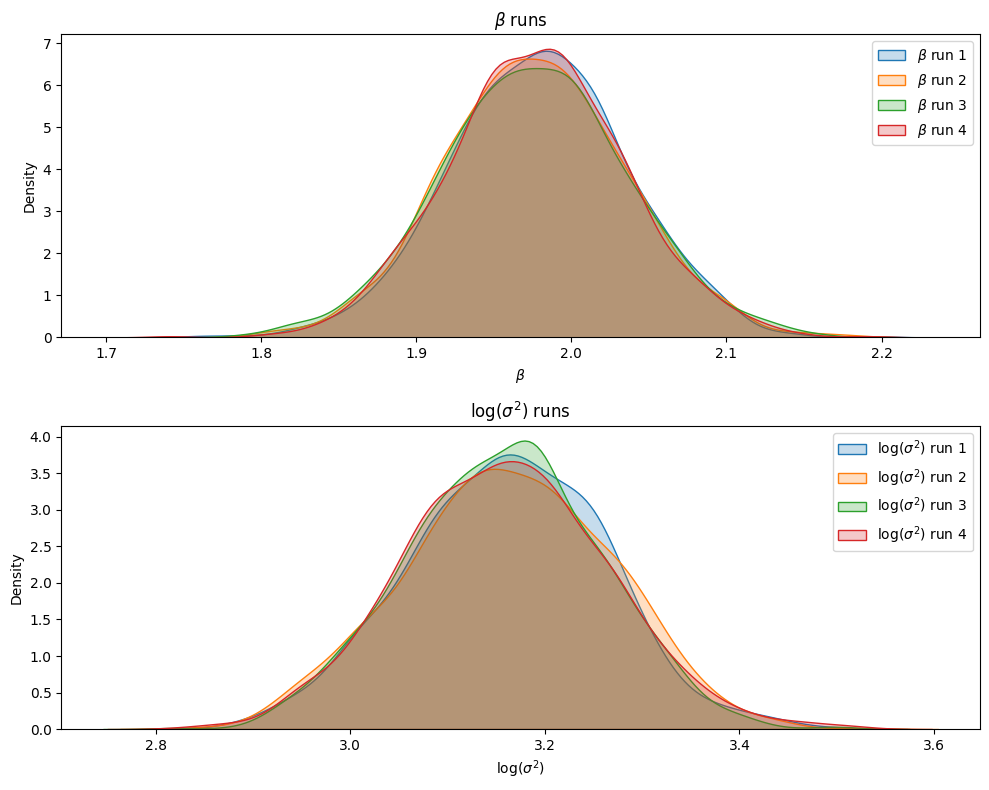

In [825]:
# Create a figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

b_0_run = trace.posterior['beta'][0]
b_1_run = trace.posterior['beta'][1]
b_2_run = trace.posterior['beta'][2]
b_3_run = trace.posterior['beta'][3]
l_0_run = trace.posterior['log_sigma2'][0]
l_1_run = trace.posterior['log_sigma2'][1]
l_2_run = trace.posterior['log_sigma2'][2]
l_3_run = trace.posterior['log_sigma2'][3]

# For beta runs
axes[0].set_title(r"$\beta$ runs")
sb.kdeplot(b_0_run, label=r"$\beta$ run 1", fill=True, ax=axes[0])
sb.kdeplot(b_1_run, label=r"$\beta$ run 2", fill=True, ax=axes[0])
sb.kdeplot(b_2_run, label=r"$\beta$ run 3", fill=True, ax=axes[0])
sb.kdeplot(b_3_run, label=r"$\beta$ run 4", fill=True, ax=axes[0])
axes[0].set_xlabel(r"$\beta$")
axes[0].set_ylabel("Density")
axes[0].legend()

# For log(sigma^2) runs
axes[1].set_title(r"$\log(\sigma^2)$ runs")
sb.kdeplot(l_0_run, label=r"$\log(\sigma^2)$ run 1", fill=True, ax=axes[1])
sb.kdeplot(l_1_run, label=r"$\log(\sigma^2)$ run 2", fill=True, ax=axes[1])
sb.kdeplot(l_2_run, label=r"$\log(\sigma^2)$ run 3", fill=True, ax=axes[1])
sb.kdeplot(l_3_run, label=r"$\log(\sigma^2)$ run 4", fill=True, ax=axes[1])
axes[1].set_xlabel(r"$\log(\sigma^2)$")
axes[1].set_ylabel("Density")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

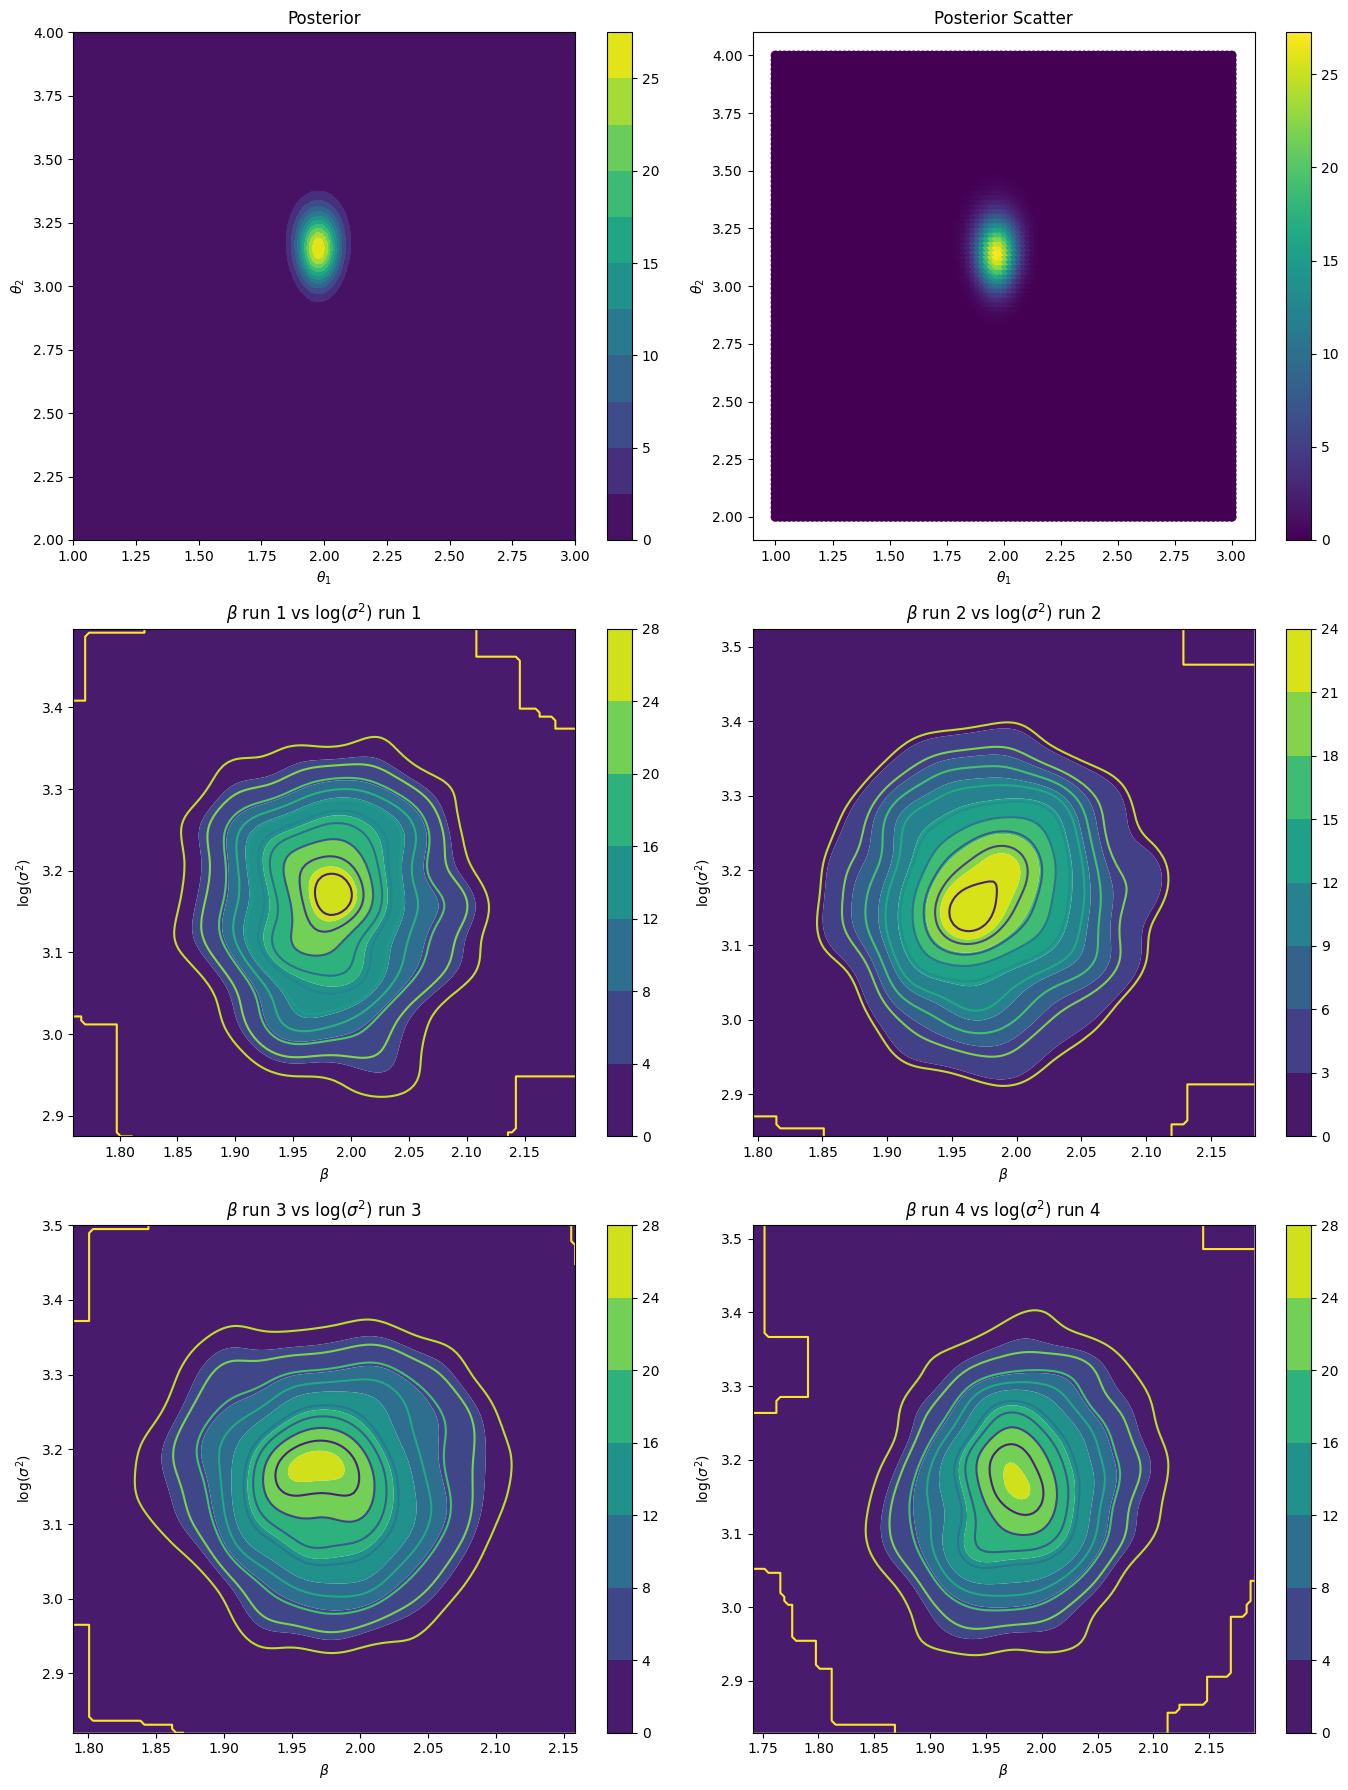

In [826]:
# Hamiltonian computation
n_points = 100
thetas_1s = np.linspace(1, 3, n_points)
theta_2s = np.linspace(2, 4, n_points)

# Create a meshgrid
theta_1_grid, theta_2_grid = np.meshgrid(thetas_1s, theta_2s)

# Vectorize the Hamiltonian computation
vectorized_Hamiltonian = np.vectorize(lambda t1, t2: np.exp(-Hamiltonian(np.array([t1, t2]), MODEL) - lnZ) )

# Compute H for the entire grid
H = vectorized_Hamiltonian(theta_1_grid, theta_2_grid)

# Create a figure with 3 rows and 2 columns of subplots
fig, ax = plt.subplots(3, 2, figsize=(14, 18))

# Plot Hamiltonian contour
contourf_h = ax[0, 0].contourf(thetas_1s, theta_2s, H, 10, cmap='viridis')
fig.colorbar(contourf_h, ax=ax[0, 0])
ax[0, 0].set_xlabel(r"$\theta_1$")
ax[0, 0].set_ylabel(r"$\theta_2$")
ax[0, 0].set_title("Posterior")

# Plot scatter plot of the Posterior") contour
scatter_h = ax[0, 1].scatter(theta_1_grid, theta_2_grid, c=H, cmap='viridis')
fig.colorbar(scatter_h, ax=ax[0, 1])
ax[0, 1].set_xlabel(r"$\theta_1$")
ax[0, 1].set_ylabel(r"$\theta_2$")
ax[0, 1].set_title("Posterior Scatter")

# Function to plot KDE contours
def plot_kde_contour(ax, x, y, title):
    contourf = az.plot_kde(x, y, ax=ax, fill_last=True, contour_kwargs={'colors': None, 'cmap': plt.cm.viridis_r, 'levels': 10})
    fig.colorbar(contourf.collections[0], ax=ax)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\log(\sigma^2)$")
    ax.set_title(title)

# Data for beta and log(sigma^2) runs
beta_runs = [b_0_run, b_1_run, b_2_run, b_3_run]
log_sigma2_runs = [l_0_run, l_1_run, l_2_run, l_3_run]
titles = [
    r"$\beta$ run 1 vs $\log(\sigma^2)$ run 1",
    r"$\beta$ run 2 vs $\log(\sigma^2)$ run 2",
    r"$\beta$ run 3 vs $\log(\sigma^2)$ run 3",
    r"$\beta$ run 4 vs $\log(\sigma^2)$ run 4"
]

# Plot KDE contours for each run
for i in range(4):
    plot_kde_contour(ax[(i // 2) + 1, i % 2], beta_runs[i], log_sigma2_runs[i], titles[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()